# Calculating transformations between images

In which we discover optimization, cost functions and how to use them.

In [1]:
# - compatibility with Python 3
from __future__ import print_function  # print('me') instead of print 'me'
from __future__ import division  # 1/2 == 0.5, not 0

In [2]:
# - show figures inside the notebook
%matplotlib inline

In [3]:
# - import common modules
import numpy as np  # the Python array package
import matplotlib.pyplot as plt  # the Python plotting package

In [4]:
# - set gray colormap and nearest neighbor interpolation by default
plt.rcParams['image.cmap'] = 'gray'
plt.rcParams['image.interpolation'] = 'nearest'

## Introduction

We often want to work out some set of spatial transformations that will make one image be a better match to another.

One example is motion correction in FMRI.  We know that the subject moves over the course of an FMRI run.  To correct for this, we may want to take each volume in the run, and match this volume to the first volume in the run.  To do this, we need to work out what the best set of transformations are to match - say - volume 1 to volume 0.

## Get the data

We start with a single slice from the each of the first two volumes in the EPI (BOLD) data.

We load the 4D EPI image, and get the data:

In [5]:
import nibabel as nib
img = nib.load('ds107_sub012_t1r2.nii')
data = img.get_data()
data.shape

(64, 64, 35, 166)

We need to make our data into floating point to make processing easier later

In [6]:
data = data.astype(np.float32)

Get the first and second volumes:

In [7]:
vol0 = data[..., 0]
vol1 = data[..., 1]
vol1.shape

(64, 64, 35)

Now we get our slices.  Here I am getting slice index 17 in z, from the first volume:

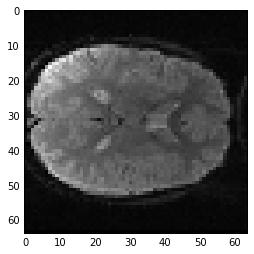

In [8]:
mid_vol0 = vol0[:, :, 17]
plt.imshow(mid_vol0)

Here is the corresponding slice from volume 1:

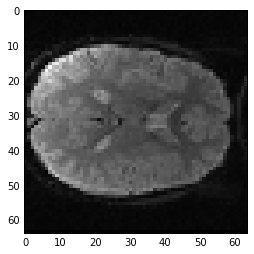

In [9]:
mid_vol1 = vol1[:, :, 17]
plt.imshow(mid_vol1)

We might want to match these two slices so they are in the same position.  We will try and match the slices by moving the voxel values in slice 1 so that they are a better match to the voxel values in slice 0.  Our job is to find the best set of transformations to do this.

We would like to have some automatic way to calculate these transformations.

The rest of this page is about how this automated method could (and does) work.

At the moment it is hard to see any difference between the two images.  That is still true even if we put the slices side by side:

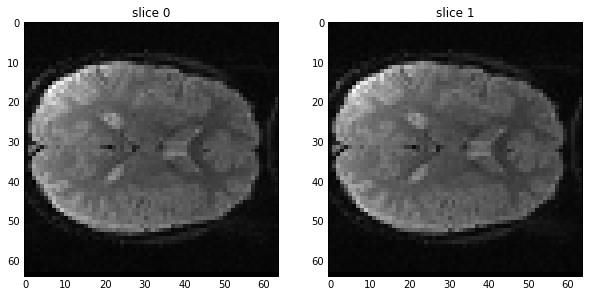

In [10]:
fig, axes = plt.subplots(1, 2, figsize=(10, 20))
axes[0].imshow(mid_vol0)
axes[0].set_title('slice 0')
axes[1].imshow(mid_vol1)
axes[1].set_title('slice 1')

The slices are very similar, because the movement between the two volumes is very small - often the movements in an FMRI run are less than a single voxel.

In order to show the automated matching procedure in action, let's start with an image that is obviously badly matched with slice 0.  We will do this by pushing slice 0 (`mid_vol1`) 8 voxels down.

After that we will try to match the shifted version (`shifted_mid_vol1`) to ``mid_vol0``:

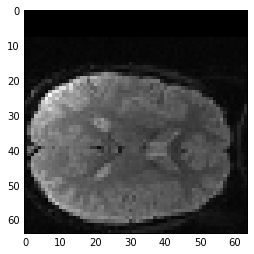

In [11]:
# Make slice full of zeros like mid_vol1 slice
shifted_mid_vol1 = np.zeros(mid_vol1.shape)
# Fill the lower 54 (of 64) x lines with mid_vol1
shifted_mid_vol1[8:, :] = mid_vol1[:-8, :]
# Now we have something like mid_vol1 but translated in the first dimension
plt.imshow(shifted_mid_vol1)

## Formulating the matching problem

Let's say we did not know how many voxels the image had been translated.  We want a good way to find out.

Let's put our problem in a more concrete form.  We are going to try translating our `shifted_mid_vol1` over the first ($x$) axis.  Call this translation $t$, so a movement of -5 voxels in $x$ gives $t=-5$.

Call the first image $\mathbf{X}$ (`mid_vol0` in our case).  Call the second image  $\mathbf{Y}$ (`shifted_mid_vol1` in our case).  $\mathbf{Y}_t$ is $\mathbf{Y}$ translated in $x$ by $t$ voxels.

$t$ is a good translation if the image $\mathbf{Y}_t$ is a good match for image $\mathbf{X}$.

We need to quantify what we mean by good match.  That is, we need some measure of quality of match, given two images $\mathbf{X}$ and $\mathbf{Y}$.  Call this measure $M(\mathbf{X}, \mathbf{Y})$, and let us specify that the value of $M(\mathbf{X}, \mathbf{Y})$ should be lower when the images match well.  We could therefore call $M(\mathbf{X}, \mathbf{Y})$ a *mismatch* function.

Now we can formulate our problem - we want to find the translation $t$ that gives the lowest value of $M(\mathbf{X}, \mathbf{Y_t})$.

Practically, we are going to need the following things:

* A function to generate $\mathbf{Y_t}$;
* A function to give the mismatch between two images.

Here's the function to generate $\mathbf{Y_t}$ - the image $\mathbf{Y}$ shifted by $t$ voxels in $x$:

In [12]:
def x_trans_slice(img_slice, x_vox_trans):
    """ Make a new copy of `img_slice` translated by `x_vox_trans` voxels
    
    `x_vox_trans` can be positive or negative
    """
    # Make a 0-filled array of same shape as `img_slice`
    trans_slice = np.zeros(img_slice.shape)
    # Use slicing to select voxels out of the image and move them
    # Up or down on the first (x) axis
    if x_vox_trans < 0:
        trans_slice[:x_vox_trans, :] = img_slice[-x_vox_trans:, :]
    elif x_vox_trans == 0:
        trans_slice[:, :] = img_slice
    else:
        trans_slice[x_vox_trans:, :] = img_slice[:-x_vox_trans, :]
    return trans_slice

## Choosing a metric for image mismatch

Next we need a mismatch function that accepts two images, and returns a scalar value that is low when the images are well matched.

We could imagine a mismatch measure that used the values from subtracting the two images:

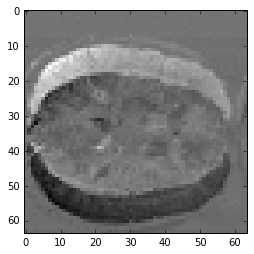

In [13]:
plt.imshow(mid_vol0 - shifted_mid_vol1)

Can we take the sum of this difference as our scalar measure of mismatch?

No, because the negative numbers (black) will cancel out the positive numbers (white).  We need something better:

In [14]:
def mean_abs_mismatch(slice0, slice1):
    """ Mean absoute difference between images
    """
    return np.mean(np.abs(slice0 - slice1))

Now we can check different values of translation with our mismatch function.  We move the image up and down for a range of values of $t$ and recalculate the mismatch measure for every candidate translation:

In [15]:
mismatches = []
translations = range(-25, 15)  # Candidate values for t
for t in translations:
    # Make the translated image Y_t
    unshifted = x_trans_slice(shifted_mid_vol1, t)
    # Calculate the mismatch
    mismatch = mean_abs_mismatch(unshifted, mid_vol0)
    # Store it for later
    mismatches.append(mismatch)

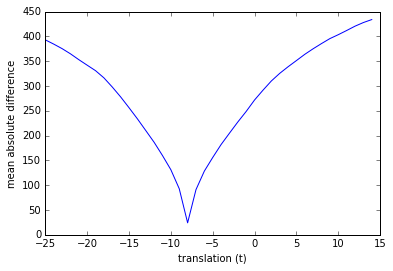

In [16]:
plt.plot(translations, mismatches)
plt.xlabel('translation (t)')
plt.ylabel('mean absolute difference')

We can try other measures of mismatch.  Another measure of how well the images match might be the correlation of the voxel values at each voxel.  When the images are well matched, we expect black values in one image to be matched with black in the other, ditto for white.

0.9981194331127774

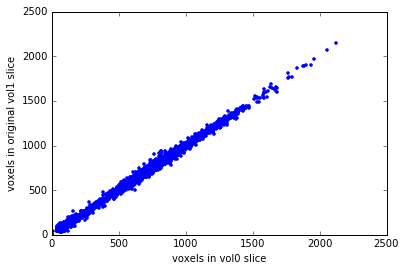

In [17]:
# Number of voxels in the image
n_voxels = np.prod(mid_vol1.shape)
# Reshape vol0 slice as 1D vector
mid_vol0_as_1d = mid_vol0.reshape(n_voxels)
# Reshape vol1 slice as 1D vector
mid_vol1_as_1d = mid_vol1.reshape(n_voxels)
# These original slices should be very close to each other already
# So - plotting one set of image values against the other should
# be close to a straight line
plt.plot(mid_vol0_as_1d, mid_vol1_as_1d, '.')
plt.xlabel('voxels in vol0 slice')
plt.ylabel('voxels in original vol1 slice')
# Correlation coefficient between them
np.corrcoef(mid_vol0_as_1d, mid_vol1_as_1d)[0, 1]

0.44628693638267175

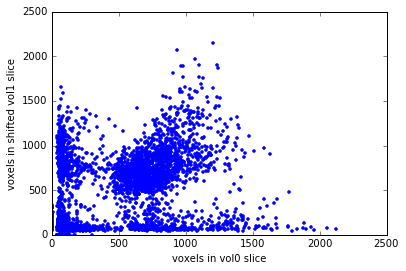

In [18]:
# The shifted slice will be less well matched
# Therefore the line will be less straight and narrow
plt.plot(mid_vol0_as_1d, shifted_mid_vol1.ravel(), '.')
plt.xlabel('voxels in vol0 slice')
plt.ylabel('voxels in shifted vol1 slice')
# Correlation coefficient between them will be nearer 0
np.corrcoef(mid_vol0_as_1d, shifted_mid_vol1.ravel())[0, 1]

We expect that the correlation will be high and positive when the images are well matched.  Our *mismatch measure*, on the other hand, should be *low* when the images are well-matched.  So, we can use the negative correlation as our mismatch measure:

In [19]:
def correl_mismatch(slice0, slice1):
    """ Negative correlation between the two images, flattened to 1D """
    correl = np.corrcoef(slice0.ravel(), slice1.ravel())[0, 1]
    return -correl

In [20]:
correl_mismatches = []
translations = range(-25, 15)  # Candidate values for t
for t in translations:
    unshifted = x_trans_slice(shifted_mid_vol1, t)
    mismatch = correl_mismatch(unshifted, mid_vol0)
    correl_mismatches.append(mismatch)

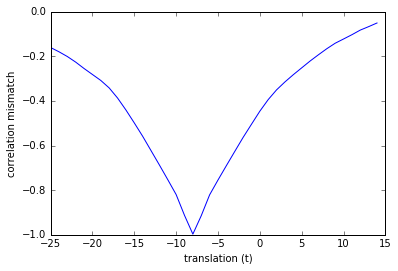

In [21]:
plt.plot(translations, correl_mismatches)
plt.xlabel('translation (t)')
plt.ylabel('correlation mismatch')

So far we have only tried translations of integer numbers of voxels (0, 1, 2, 3...).

How about non-integer translations?  Will these work?

To do a non-integer translation, we have to think more generally about how to make an image that matches another image, after a transformation.

## Resampling in 2D

We need a more general resampling algorithm.  This is like the interpolation we do for slice timing, but in two dimensions.

Let's say we want to do a voxel translation of 0.5 voxels in X.  The way we might go about this is the following.

To start, here are some names:

* `img0` is the image we are trying to match to (in our case `mid_vol0`);
* `img1` is the image we are trying to match by moving (in our case `shifted_mid_vol1`);
* `trans` is the transformation from pixel coordinates in `img1` to pixel coordinates in `img0` (in our case adding 0.5 to the first coordinate value, so that [0, 0] becomes [0.5, 0]);
* `itrans` is the inverse of `trans`, and gives the transformation to go from pixel coordinates in `img0` to pixel coordinates in `img1`.  In our case this is *subtracting* 0.5 from the first coordinate value.

The procedure for resampling is:

* Make a 2D image the same shape as the image we want to match to (`img0`) - call this `new_img0`;
* For each pixel in `new_img0`;
    * call the pixel coordinate for this pixel: `coord_for_img0`;
    * transform `coord_for_img0` using `itrans`.  In our case this would be to subtract 0.5 from the first coordinate value ([0, 0] becomes [-0.5, 0]).  Call the transformed coordinate `coord_for_img1`;
    * Estimate the pixel value in `img1` at coordinate `coord_for_img1`. Call this value `img1_value_estimate`;
    * Insert `img1_value` into `new_img0` at coordinate `coord_for_img0`.
    
The "Estimate pixel value" step is called *resampling*.  As you can see this is the same general idea as interpolating in one dimension.  We saw one dimensional interpolation for slice timing.  There are various ways of interpolating in two or three dimensions, but one of the most obvious is the simple extension of linear interpolation to two (or more) dimensions - [bilinear interpolation](http://en.wikipedia.org/wiki/Bilinear_interpolation).

The `scipy.ndimage` library has routines for resampling in 2 or 3 dimensions:

In [22]:
import scipy.ndimage as snd

In fact the ``affine_transform`` function from `scipy.ndimage` will do the whole process for us.

In [23]:
def fancy_x_trans_slice(img_slice, x_vox_trans):
    """ Make a new copy of `img_slice` translated by `x_vox_trans` voxels
    
    `x_vox_trans` can be positive or negative, and can be a float.
    """
    # Resample image using bilinear interpolation (order=1)
    trans_slice = snd.affine_transform(img_slice, [1, 1], [-x_vox_trans, 0], order=1)
    return trans_slice

In [24]:
fine_mismatches = []
fine_translations = np.linspace(-25, 15, 100)
for t in fine_translations:
    unshifted = fancy_x_trans_slice(shifted_mid_vol1, t)
    mismatch = correl_mismatch(unshifted, mid_vol0)
    fine_mismatches.append(mismatch)

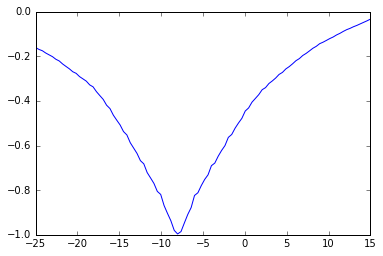

In [25]:
plt.plot(fine_translations, fine_mismatches)

We are looking for the best x translation.  At the moment we have to sample lots of x translations and then choose the best.  Is there a better way?

## Optimization

*Optimization* is a field of mathematics / computer science that solves this exact problem:

http://en.wikipedia.org/wiki/Mathematical_optimization

There are many optimization routines in Python, MATLAB and other languages.  These routines typically allow you to pass some function, called the *objective* function, or the *cost* function.  The optimization routine returns the parameters of the cost function that give the lowest value.

In our case, the cost function we need to minimize will accept one parameter (the translation), and return the mismatch value for that translation.  So, it will need to create the image $\mathbf{X_t}$ and return $M(\mathbf{X}, \mathbf{Y_t})$.

What does it mean to "pass" a function in Python.  Remember, in Python, [functions are objects too](functions_are_objects.ipynb).

The optimization works by running the cost function at some starting value of the parameter (in our case, x translation), and using an algorithm to choose the next value of the parameter to try.  It continues trying new values until it finds a parameter value for which very small changes of the parameter up or down only increase the cost function value. At this point the routine stops and returns the parameter value.

To write our cost function, we will use the fact that Python functions can access variables defined in the [global scope](global_scope.ipynb).  In our case the function `cost_function` can access variables `shifted_mid_vol1` and `mid_vol0` that we defined in the top level (global) scope of the notebook:

In [26]:
def cost_function(x_trans):
    # Function can use image slices defined in the global (notebook) scope
    # Calculate X_t - image translated by x_trans
    unshifted = fancy_x_trans_slice(shifted_mid_vol1, x_trans)
    # Return mismatch measure for the translated image X_t
    return correl_mismatch(unshifted, mid_vol0)

In [27]:
# value of the negative correlation for no translatino
cost_function(0)

-0.44628693638267175

In [28]:
# value of the negative correlation for translation of -8 voxels
cost_function(-8)

-0.99703080735234673

Now we get a general optimizing routine from the `scipy` Python library.  `fmin_powell` finds the minimum of a function using [Powell's method](https://en.wikipedia.org/wiki/Powell%27s_method) of numerical optimization:

In [29]:
from scipy.optimize import fmin_powell

We pass the ``fmin_powell`` routine our Python cost function, and a starting value of zero for the translation:

In [30]:
fmin_powell(cost_function, [0])

Optimization terminated successfully.
         Current function value: -0.997032
         Iterations: 2
         Function evaluations: 27


array(-7.996026691215329)

The function ran, and found that a translation of very nearly -8 gave the smallest value for our cost function.

What actually happened there?  Let's track the progress of `fmin_powell` using a callback function:

In [31]:
def my_callback(params):
   print("Trying parameters " + str(params))

`fmin_powell` calls this `my_callback` function when it is testing a new set of parameters.

In [32]:
best_params = fmin_powell(cost_function, [0], callback=my_callback)
best_params

Trying parameters [-7.99501254]
Trying parameters [-7.99602669]
Optimization terminated successfully.
         Current function value: -0.997032
         Iterations: 2
         Function evaluations: 27


array(-7.996026691215329)

The optimization routine `fmin_powell` is trying various different translations, finally coming to the optimimum (minimum) translation of very nearly -8.

## More than one parameter

How about adding y translation as well?

Our optimization routine could deal with this in a very simple way - by optimizing the x translation, then the y translation, like this:

* Adjust the x translation until it has reached a minimum, then;
* Adjust the y translation until it has reached a minimum, then;
* Repeat x, y minimization until the minimum for both is stable.

Although we could do that, in fact `fmin_powell` does something slightly more complicated when looking for the next best set of parameters to try.  The details aren't important to the general idea of searching over different parameter values to find the lowest value for the cost function.

In [33]:
def fancy_xy_trans_slice(img_slice, x_y_trans):
    """ Make a new copy of `img_slice` translated by `x_y_trans` voxels
    
    x_y_trans is a sequence or array length 2, containing the (x, y) translations in voxels.
    
    Values in `x_y_trans` can be positive or negative, and can be floats.
    """
    x_y_trans = np.array(x_y_trans)
    # Resample image using bilinear interpolation (order=1)
    trans_slice = snd.affine_transform(img_slice, [1, 1], -x_y_trans, order=1)
    return trans_slice

In [34]:
def fancy_cost_at_xy(x_y_trans):
    """ Give cost function at xy translation values `x_y_trans`
    """
    unshifted = fancy_xy_trans_slice(shifted_mid_vol1, x_y_trans)
    return correl_mismatch(unshifted, mid_vol0)

Do the optimization of `fancy_cost_at_xy` using `fmin_powell`:

In [35]:
best_params = fmin_powell(fancy_cost_at_xy, [0, 0], callback=my_callback)
best_params

Trying parameters [-7.99501254  0.        ]
Trying parameters [-7.99602669  0.        ]
Optimization terminated successfully.
         Current function value: -0.997032
         Iterations: 2
         Function evaluations: 133


array([-7.99602669,  0.        ])

(You probably noticed that `fmin_powell` appears to be sticking to the right answer for y translation (0), without printing out any evidence that it is trying other y values.  This is because of the way that the Powell optimization works - it is in effect doing separate 1-parameter minimizations in order to get the final 2-parameter minimization, and it is not reporting the intermediate steps in the 1-parameter minimizations)

## Full 3D estimate

Now we know how to do two parameters, it's easy to extend this to six parameters.

The six parameters are:

* x translation
* y translation
* z translation
* rotation around x axis (pitch)
* rotation around y axis (roll)
* rotation around z axis (yaw)

Any transformation with these parameters is called a *rigid body* transformation because the transformation cannot make the object change shape (the object is *rigid*).

Implementing the rotations is just slightly out of scope for this tutorial (we would have to convert between angles and [rotation matrices](http://en.wikipedia.org/wiki/Rotation_matrix)), so here is the 3D optimization with the three translation parameters:

To make it a bit more interesting, shift the second volume 8 voxels on the first axis, as we did for the 2D case.  We will also push the image 5 voxels forward on the second axis:

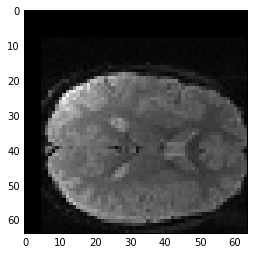

In [36]:
shifted_vol1 = np.zeros(vol1.shape)
shifted_vol1[8:, 5:, :] = vol1[:-8, :-5, :]
plt.imshow(shifted_vol1[:, :, 17])

We define resampling for any given x, y, z translation:

In [37]:
def xyz_trans_vol(vol, x_y_z_trans):
    """ Make a new copy of `vol` translated by `x_y_z_trans` voxels
    
    x_y_z_trans is a sequence or array length 3, containing the (x, y, z) translations in voxels.
    
    Values in `x_y_z_trans` can be positive or negative, and can be floats.
    """
    x_y_z_trans = np.array(x_y_z_trans)
    # [1, 1, 1] says to do no zooming or rotation
    # Resample image using trilinear interpolation (order=1)
    trans_vol = snd.affine_transform(vol, [1, 1, 1], -x_y_z_trans, order=1)
    return trans_vol

Our cost function (picking up `vol0`, `shifted_vol1` from the global scope):

In [38]:
def cost_at_xyz(x_y_z_trans):
    """ Give cost function value at xyz translation values `x_y_z_trans`
    """
    unshifted = xyz_trans_vol(shifted_vol1, x_y_z_trans)
    return correl_mismatch(unshifted, vol0)

Do the optimization of `cost_at_xyz` using `fmin_powell`:

In [39]:
best_params = fmin_powell(cost_at_xyz, [0, 0, 0], callback=my_callback)
best_params

Trying parameters [-7.57216655 -4.96610483  0.        ]
Trying parameters [-7.9967514  -4.99966753  0.        ]
Trying parameters [-7.99998292 -4.9999992   0.        ]
Optimization terminated successfully.
         Current function value: -0.995145
         Iterations: 3
         Function evaluations: 270


array([-7.99998292, -4.9999992 ,  0.        ])

Finally, we make a new volume from `shifted_vol1` with these transformations applied:

In [40]:
unshifted_vol1 = snd.affine_transform(shifted_vol1, [1, 1, 1], -best_params)

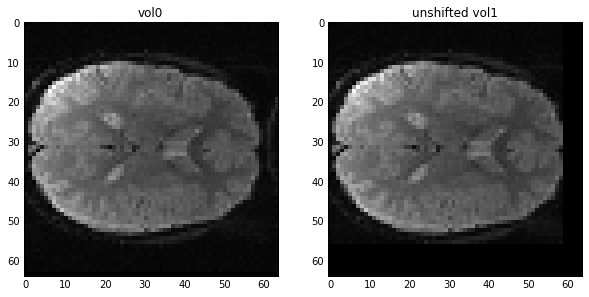

In [41]:
fig, axes = plt.subplots(1, 2, figsize=(10, 20))
axes[0].imshow(vol0[:, :, 17])
axes[0].set_title('vol0')
axes[1].imshow(unshifted_vol1[:, :, 17])
axes[1].set_title('unshifted vol1')

## Getting stuck in the wrong place

So far, all our cost function plots are simple, in the sense that they have one single obvious minimum.  For example, here is a repeat of our ealier plot of the negative correlation value, as a function of translation in x, for the shifted single slice:

In [42]:
correl_mismatches = []
translations = range(-25, 15)  # Candidate values for t
for t in translations:
    unshifted = x_trans_slice(shifted_mid_vol1, t)
    mismatch = correl_mismatch(unshifted, mid_vol0)
    correl_mismatches.append(mismatch)

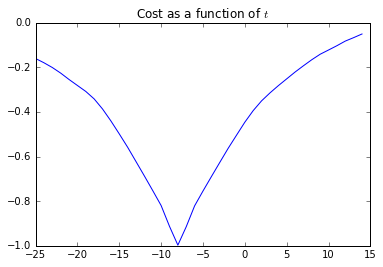

In [43]:
plt.plot(translations, correl_mismatches)
plt.title('Cost as a function of $t$')

Notice the nice single minimum at around $t=-8$.

Unfortunately, many cost functions don't have one single minimum, but several.  In fact this is so even for our simple correlation measure, if we look at larger translations (values of $t$):

In [44]:
correl_mismatches = []
translations = range(-60, 50)  # Candidate values for t
for t in translations:
    unshifted = x_trans_slice(shifted_mid_vol1, t)
    mismatch = correl_mismatch(unshifted, mid_vol0)
    correl_mismatches.append(mismatch)

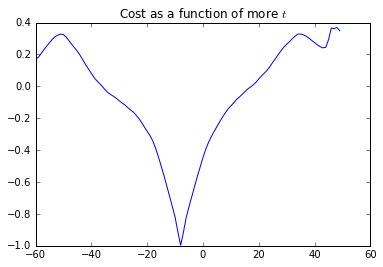

In [45]:
plt.plot(translations, correl_mismatches)
plt.title('Cost as a function of more $t$')

Remember that a minimum is a value for which the values to the left and right are higher.   So, the -8 value of $t$ is minimum (with a negative correlation value of -1), but the value at around $t=44$ is also a minimum, with a negative correlation value of around 0.2.   The value at $t=-8$ is a *global minimum* in the sense that it is the minimum with the lowest cost value across all values of $t$.  The value at around $t=44$ is a *local minimum*.

In general, our optimization routines are only able to guarantee that they have found a local minimum.  So, if we start our search in the wrong place, then the optimization routine may well find the wrong minimum.

Here is our original 1 parameter cost function (it is the same as the version above):

In [46]:
def cost_function(x_trans):
    # Function can use image slices defined in the global (notebook) scope
    # Calculate X_t - image translated by x_trans
    unshifted = fancy_x_trans_slice(shifted_mid_vol1, x_trans)
    # Return mismatch measure for the translated image X_t
    return correl_mismatch(unshifted, mid_vol0)

Now we minimize this cost function with `fmin_powell`, but starting nearer the local minimum:

In [47]:
fmin_powell(cost_function, [35])

Optimization terminated successfully.
         Current function value: 0.241603
         Iterations: 2
         Function evaluations: 55


array(43.00000063722926)

Here we took a very bad starting value, but we would run the same risk if the images started off much further apart and we gave a starting value of 0.

One major part of using optimization, is being aware that it is possible for the optimization to find a "best" value that is a local rather than a global minimum.  The art of optimization is finding a minimization algorithm and mismatch metric that are well-adapted to the particular problem.